In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from scipy.stats import ttest_ind, ttest_ind_from_stats, ks_2samp
from scipy.special import stdtr
import seaborn as sns
sns.set_style("whitegrid")

np.random.seed(2017)

Populating the interactive namespace from numpy and matplotlib


In [2]:
delay = pd.read_csv('delay_95.csv')

In [10]:
taxi = pd.read_csv('resultswithdelays.csv', index_col=0)

In [11]:
merged = taxi.drop(['geometry','line','name','notes','objectid','url',
           'buffer','delayed','nameline','Station'],
          axis=1)
merged.head()

,keycol,delay,Taxi_Rides,Date,Hour,new_station
0,636_1_7,0,22,1,7,636
1,636_1_8,0,24,1,8,636
2,636_1_9,0,19,1,9,636
3,636_1_10,0,16,1,10,636
4,636_1_11,0,21,1,11,636


In [59]:
merged[['keycol','Taxi_Rides']].to_csv('taxirides.csv', index=False)

In [63]:
delay20 = pd.read_csv('delay_20min.csv')

In [68]:
merged2 = pd.merge(delay20, merged[['keycol','Taxi_Rides','Date','Hour','new_station']], how='inner', on='keycol')
merged2.head()

,keycol,delay,Taxi_Rides,Date,Hour,new_station
0,0_1_7,1,5,1,7,0
1,0_1_7,1,5,1,7,0
2,0_1_7,1,2,1,7,0
3,0_1_7,1,2,1,7,0
4,0_1_7,1,1,1,7,0


In [71]:
def getreport(merged):
    the_delays = merged[merged.delay>0]
    the_control = merged[merged.delay==0]
    print "number of delays: " + str(len(the_delays))
    print "number of good service (kind of): " + str(len(the_control))
    print "mean taxi rides on delays: " + str(the_delays.Taxi_Rides.mean())
    print "mean taxi rides on good services: " + str(the_control.Taxi_Rides.mean())
    t, p = ttest_ind(the_delays.Taxi_Rides, the_control.Taxi_Rides, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))
    
    by_hour = pd.DataFrame({'delay': the_delays.groupby('Hour').mean()['Taxi_Rides'],
                        'control': the_control.groupby('Hour').mean()['Taxi_Rides']})
    # let's test the p-value by hour
    ks_p_values = []
    ttest_p_values = []
    for i in range(7,21):
        delay_per_hour = the_delays[the_delays.Hour == i]['Taxi_Rides']
        control_per_hour = the_control[the_control.Hour == i]['Taxi_Rides']
        t, pt = ttest_ind(control_per_hour,delay_per_hour, equal_var=False)
        k,pk = ks_2samp(control_per_hour, delay_per_hour)
        ks_p_values.append(pk)
        ttest_p_values.append(pt)
    by_hour['ks p-values'] = ks_p_values
    by_hour['t-test p-values'] = ttest_p_values
    by_hour['significant'] = by_hour['t-test p-values'].apply(lambda x: 1 if x<0.06 else 0)
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    plt.xticks(by_hour.index)
    ax.scatter(by_hour[by_hour.significant==1].index,
               by_hour[by_hour.significant==1].delay,
              c="black",s=100, zorder=10, label='significant')
    by_hour.control.plot(ax=ax, label="Good Service", c='gray', linewidth=2)
    by_hour.delay.plot(ax=ax, label="Delay", c='IndianRed', linewidth=4)
    ax.set_ylabel("Taxi Pickups")
    #ax.set_xlabel("")
    plt.legend(loc='lower right')
    ax.grid(color='#dddddd')
    ax.set_title("Number of Taxi Pickups Within 300 Feet From Stations", fontweight='bold', fontsize=16)

    
    #STATION
    by_station = pd.DataFrame({'delay': the_delays.groupby('new_station').mean()['Taxi_Rides'],
                        'control': the_control.groupby('new_station').mean()['Taxi_Rides']})
    by_station.dropna(inplace=True)
    
    ks_p_values = []
    ttest_p_values = []
    for i in by_station.index:
        delay_per_station = the_delays[the_delays.new_station == i]['Taxi_Rides']
        control_per_station = the_control[the_control.new_station == i]['Taxi_Rides']
        t, pt = ttest_ind(control_per_station,delay_per_station, equal_var=False)
        k,pk = ks_2samp(control_per_station, delay_per_station)
        ks_p_values.append(pk)
        ttest_p_values.append(pt)
    
    by_station['ks p-values'] = ks_p_values
    by_station['t-test p-values'] = ttest_p_values
    by_station['significant'] = by_station['t-test p-values'].apply(lambda x: 1 if x<0.05 else 0)
    by_station.head()
    
    significant_stations = by_station[by_station.significant==1].copy().reset_index()
    significant_stations.rename(columns={'new_station':'id'}, inplace=True)
    significant_stations['id'] = significant_stations['id'].apply(str)
    subwayst = pd.read_csv("subway_station.csv")
    subwayst.head()
    subway = subwayst[['name','id']]
    ss = pd.merge(significant_stations, subway, how='left', on='id')
    
    #DATE
    by_date = pd.DataFrame({'delay': the_delays.groupby(['Date']).mean()['Taxi_Rides'],
                        'control': the_control.groupby(['Date']).mean()['Taxi_Rides']})
    
    # let's test the p-value by station
    ks_p_values = []
    ttest_p_values = []
    for i in by_date.index:
        delay = the_delays[(the_delays.Date==i)]['Taxi_Rides']
        control = the_control[(the_control.Date==i)]['Taxi_Rides']
        t, pt = ttest_ind(control,delay, equal_var=False)
        k,pk = ks_2samp(control, delay)
        ks_p_values.append(pk)
        ttest_p_values.append(pt)
        
    by_date['ks p-values'] = ks_p_values
    by_date['t-test p-values'] = ttest_p_values
    by_date['significant'] = by_date['t-test p-values'].apply(lambda x: 1 if x<0.05 else 0)
    by_date.head()
    
    significant_date = by_date[by_date.significant==1].copy().reset_index()
    #significant_date.dropna()
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    plt.xticks(by_date.index)
    ax.scatter(by_date[by_date.significant==1].index,
               by_date[by_date.significant==1].delay,
              c="black",s=100, zorder=10, label='significant')
    by_date.control.plot(ax=ax, label="Good Service", c='gray', linewidth=2)
    by_date.delay.plot(ax=ax, label="Delay", c='IndianRed', linewidth=4)
    ax.set_ylabel("Taxi Pickups")
    #ax.set_xlabel("")
    plt.legend(loc='upper left')
    ax.grid(color='#dddddd')
    ax.set_title("Number of Taxi Pickups Within 300 Feet From Stations", fontweight='bold', fontsize=16)
    
    return ss



### threshold = 95 percentiles

number of delays: 20634
number of good service (kind of): 36486
mean taxi rides on delays: 23.3713288747
mean taxi rides on good services: 22.6194156663
ttest_ind:            t = 2.62752  p = 0.00860418


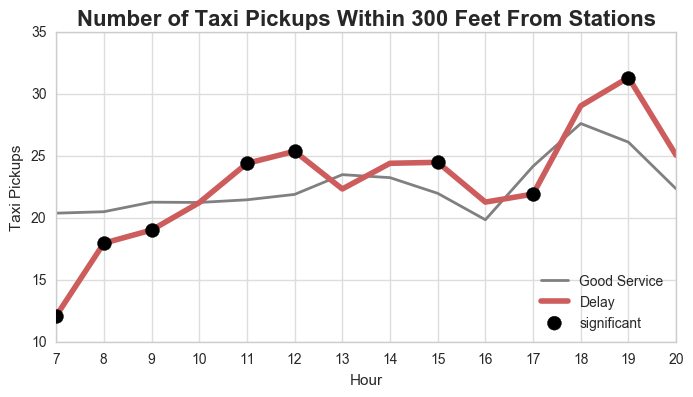

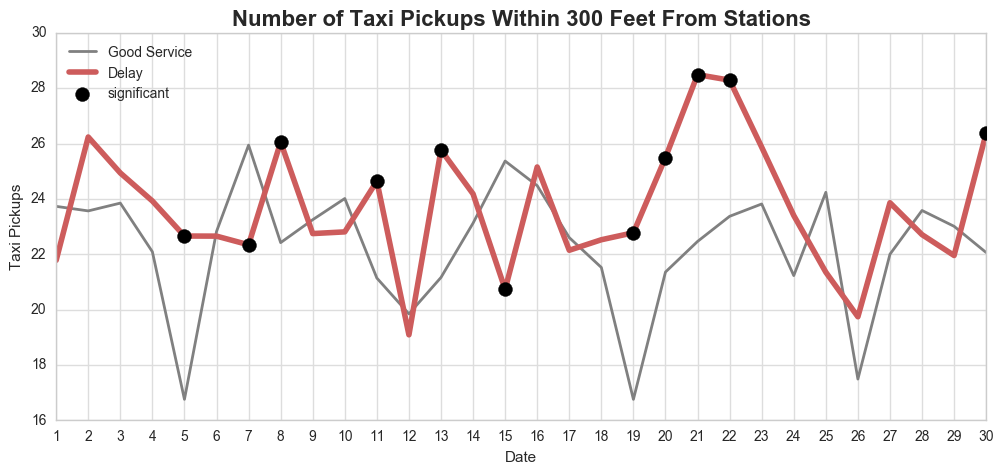

In [72]:
ss_95 = getreport(merged)

### these are the 95 percentiles

{'1': 17.766666666700001,

'23': 21.550000000000001,

'45': 21.066666666700002,

'6': 18.7166666667,

'L': 11.75}

### threshold = 20 minutes

number of delays: 22738
number of good service (kind of): 34382
mean taxi rides on delays: 21.0011434603
mean taxi rides on good services: 24.1408876738
ttest_ind:            t = -11.494  p = 1.54017e-30


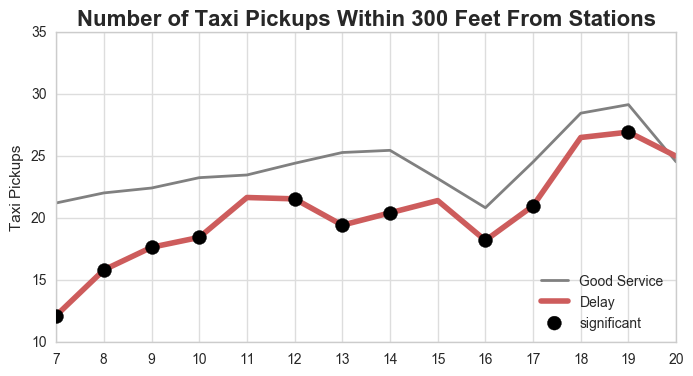

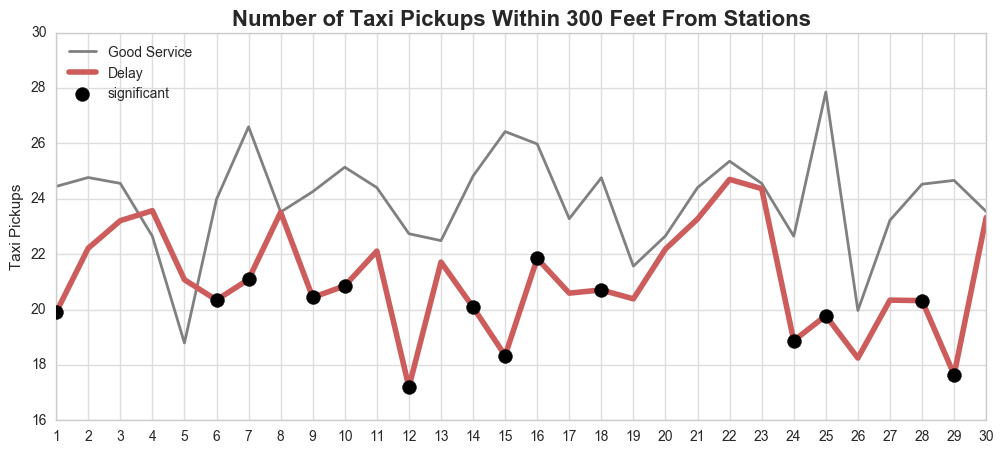

In [69]:
ss_20 = getreport(merged2)

In [74]:
ss_95[ss_95.control>ss_95.delay]

,id,control,delay,ks p-values,t-test p-values,significant,name
0,108,2.000000,1.000000,1.897988e-02,0.000000e+00,1,207 St
4,128,218.069388,206.011494,1.353173e-01,2.990839e-02,1,34 St - Penn Station
21,301,1.085714,1.000000,9.989704e-01,1.322372e-02,1,Harlem - 148 St
29,625,19.489960,18.266272,5.946737e-03,1.049817e-02,1,96 St
30,626,74.216028,64.469697,3.148262e-10,1.129143e-11,1,86 St
31,627,35.804348,29.440559,5.952875e-13,1.479888e-15,1,77 St
32,628,27.117647,22.753425,8.008617e-13,8.643097e-08,1,68 St - Hunter College
34,631,58.742515,55.023529,1.882358e-02,1.572493e-02,1,Grand Central - 42 St
35,632,47.972112,37.148810,1.225869e-20,6.807759e-19,1,33 St
36,633,49.701681,46.805556,3.317034e-10,4.851527e-02,1,28 St


In [76]:
len(ss_95[ss_95.control<ss_95.delay])

30

In [79]:
ss_95.to_csv("significant_stations_95percentiles.csv")

In [80]:
ss_20.to_csv("significant_stations_20minutes.csv")